<a href="https://colab.research.google.com/github/itssofiarce/AA1-TUIA-Petetta-Arce/blob/sofi_main/TP_integrador_AA1_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# De scikit-learn...

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

# Estandarización y modelado
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import make_column_selector
# Division de los datos
from sklearn.model_selection import train_test_split

# Normalización
from sklearn.preprocessing import MinMaxScaler

# Regresiones
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV, LogisticRegression

# ML metricas
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
path= './weatherAUS.csv'
df = pd.read_csv(path, usecols=range(1,25))
df.head()

In [ ]:
### Busco duplicados
if not df.duplicated().any():
  print('No hay registros duplicados')

In [ ]:
class ColDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    return X.drop(['Date'], axis=1)

In [ ]:
class LocDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    costa_este = [' Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' ]
    X.loc[X['Location'].isin(costa_este), 'Location'] = 'costa_este'
    return X[X['Location'] == 'costa_este']

In [ ]:
class CatFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X['WindGustDir'] = X.groupby('Location')['WindGustDir'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir9am'] = X.groupby('Location')['WindDir9am'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir3pm'] = X.groupby('Location')['WindDir3pm'].transform(lambda x: x.fillna(x.mode()[0]))

      return X

In [ ]:
class NumFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      remanining_vnul_columns = X.columns[X.isna().any()].tolist()
      for col in remanining_vnul_columns:
        X[col] =  X[col].fillna(X[col].mean())

      return X

In [ ]:
# https://www.mdpi.com/2078-2489/13/4/163 Como las variables de la dirección de los vientos pueden tener hasta 16 direcciones diferentes, para convertirlos a variables numéricas, se tiene encuenta una distribución circular. Por eso, cada una de las variables se dividió en dos: Una con el seno y otra con el coseno del angulo
class CoordRecat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        coord = {
            'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
            'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
            'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
            'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5,
        }

        # Aplicar la recategorización
        for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
            X[col] = X[col].map(coord)
            X[f'{col}_rad'] = np.deg2rad(X[col])
            X[f'{col}_sin'] = np.sin(X[f'{col}_rad']).round(5)
            X[f'{col}_cos'] = np.cos(X[f'{col}_rad']).round(5)

        # Eliminar columnas originales y columnas radianes
        columns_to_drop = [f'{col}_rad' for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']] + ['WindGustDir', 'WindDir9am', 'WindDir3pm']
        X = X.drop(columns=columns_to_drop, axis=1)

        return X

In [ ]:
class LocEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      dummies = pd.get_dummies(X['Location'], dtype=int)
      X = pd.concat([X, dummies], axis=1)
      X.drop('Location', axis=1, inplace=True)

      return X

In [ ]:
class ResetIndex(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reset_index(drop=True)

In [ ]:
class BoolYNDropperEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X.dropna(subset=['RainToday'], inplace=True)
      X['RainTomorrow'] = X['RainTomorrow'].map({'No': 0, 'Yes': 1}).astype(float)
      X['RainToday'] = X['RainToday'].map({'No': 0, 'Yes': 1}).astype(float)

      return X

In [ ]:
class Standarizer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    # Exclusión de variables booleanas y RainfallTmorrow porque no serán estandarizaradas
    exc_c = ['RainToday', 'RainTomorrow']#, ,'Canberra','Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

    # Estandarización
    df_sub = X[[col for col in X.columns if col not in exc_c]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_sub)

    X_scaled = pd.DataFrame(X_scaled, columns=df_sub.columns)
    for col in exc_c:
      X_scaled[f'{col}'] = X[col]

    # Nuevo DataFrame estandarizado con los nombres de las columnas originales
    return X_scaled

In [ ]:
class OutliersTreater(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    cols_with_ouliers=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']

    for col in cols_with_ouliers:
      IQR=X[col].quantile(0.75)-X[col].quantile(0.25)
      lower_bridge=X[col].quantile(0.25)-(IQR*1.5)
      upper_bridge=X[col].quantile(0.75)+(IQR*1.5)

      X.loc[X[col]>=round(upper_bridge,2),col]=round(upper_bridge,2)
      X.loc[X[col]<=round(lower_bridge,2),col]=round(lower_bridge,2)

    return X


In [ ]:
class RLValDropper(BaseEstimator, TransformerMixin):
  def fit (self, X, y=None):
    return self
  def transform(self, X):
    X.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)
    return X


In [ ]:
preprocessor = Pipeline([
     ('drop_null_val_rl', RLValDropper()),
     ('drop_not_needed_features', ColDropper()),
     ('drop_nor_needed_locations',LocDropper()),
     ('yes_no_dropper_encoder', BoolYNDropperEncoder()),
     ('fill_null_cat', CatFiller()),
     ('fill_num_cat', NumFiller()),
     ('encode_loc', LocEncoder()),
     ('encode_wind_dir', CoordRecat()),
     ('reset_index',ResetIndex()),
     ('treat_outliers',OutliersTreater()),
     ('standariza_values', Standarizer())
])


# Train-Test split

In [ ]:
# Separación de variables explicativas y variables objetivo
X = df.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1).copy()
y = df[['RainTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
# Creo un Dataframe de TRAIN
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainTomorrow'] = y['RainTomorrow']

In [ ]:
# Creo un Dataframe de TEST
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['RainTomorrow'] = y['RainTomorrow']

In [ ]:
# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.fit_transform(df_test)

In [ ]:
df_train.head()

# Reg logistica sin balancear

In [ ]:
train_clasificacion_X = df_train.iloc[:, :-1]
y_train_clasificacion = df_train.iloc[:,-1]

In [ ]:
x_test_clasificacion = df_test.iloc[:, :-1]
y_test_clasificacion = df_test.iloc[:,-1]

In [ ]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(train_clasificacion_X, y_train_clasificacion)
valor_y_predecir = classifier.predict(x_test_clasificacion)

#metricas

from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test_clasificacion, valor_y_predecir)
acc_score = accuracy_score(y_test_clasificacion, valor_y_predecir)

In [ ]:
from sklearn.metrics import roc_curve, auc

In [ ]:
probabilidades_y = classifier.predict_proba(x_test_clasificacion)[:,-1]
fpr, tpr, thresholds = roc_curve(y_test_clasificacion, probabilidades_y)
roc_auc = auc(fpr,tpr)

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color="red", lw=2, label='CURVA ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], color="blue", lw=2, linestyle="--")
plt.xlim([0.0, 1.10])
plt.ylim([0.0, 1.10])
plt.xlabel("Tasa de Falsos positivos(FPR)")
plt.ylabel("Tasa de Verdaderos positivos(TPR)")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

In [ ]:
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

# Optimizar clasificacion

# *Aca esta lo que buscas*

In [ ]:
clasificacion_parametros = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': [None, 'l2'],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced']
}

optimizar_clasificacion = RandomizedSearchCV(
    LogisticRegression(random_state=23), clasificacion_parametros
)

optimizar_clasificacion.fit(train_clasificacion_X, y_train_clasificacion)
#para optimizar el balanceado hay que cambiar (((train_clasificacion_X, y_train_clasificacion)))
#por los correspondientes de smote

In [ ]:
modelo_optimizado_clasificacion = optimizar_clasificacion.best_estimator_

In [ ]:
y_pred_clasificacion_optimizado = modelo_optimizado_clasificacion.predict(x_test_clasificacion)


print(classification_report(y_test_clasificacion, y_pred_clasificacion_optimizado))


ConfusionMatrixDisplay(
    confusion_matrix(y_test_clasificacion, y_pred_clasificacion_optimizado)
).plot()

# Explicabilidad Clasificacion

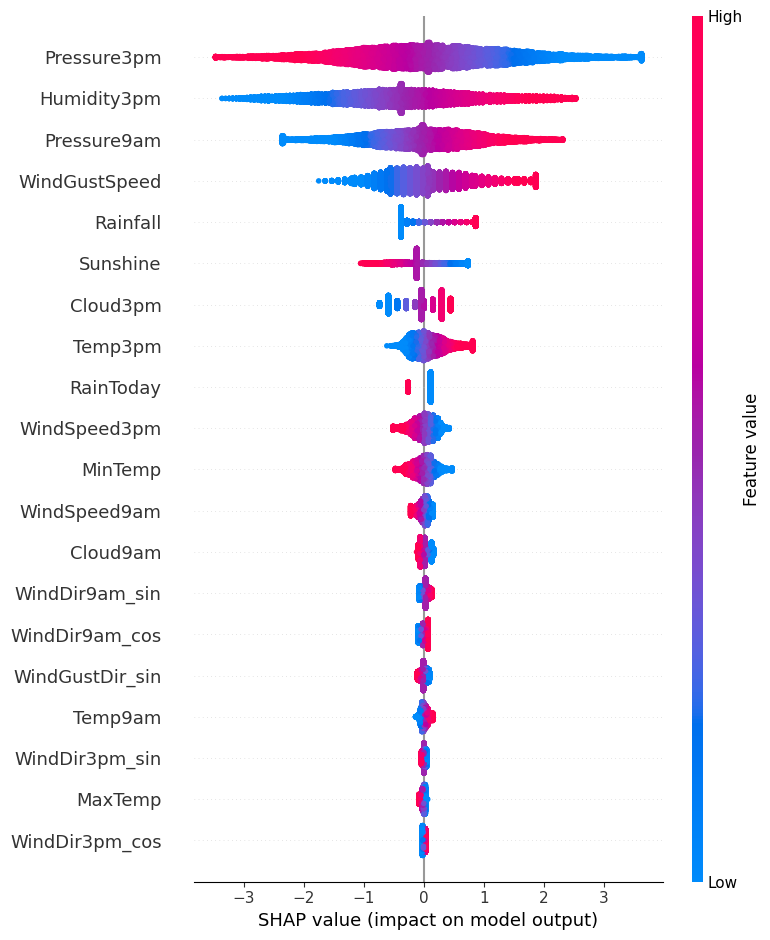

In [64]:
explicar_clasificacion = shap.LinearExplainer(
    classifier,
    train_clasificacion_X.astype("float64").copy(),
    features_names=train_clasificacion_X.columns,
)


shap_valores_clasificacion = explicar_clasificacion(
    train_clasificacion_X.astype("float64")
)

shap.summary_plot(shap_valores_clasificacion, train_clasificacion_X)

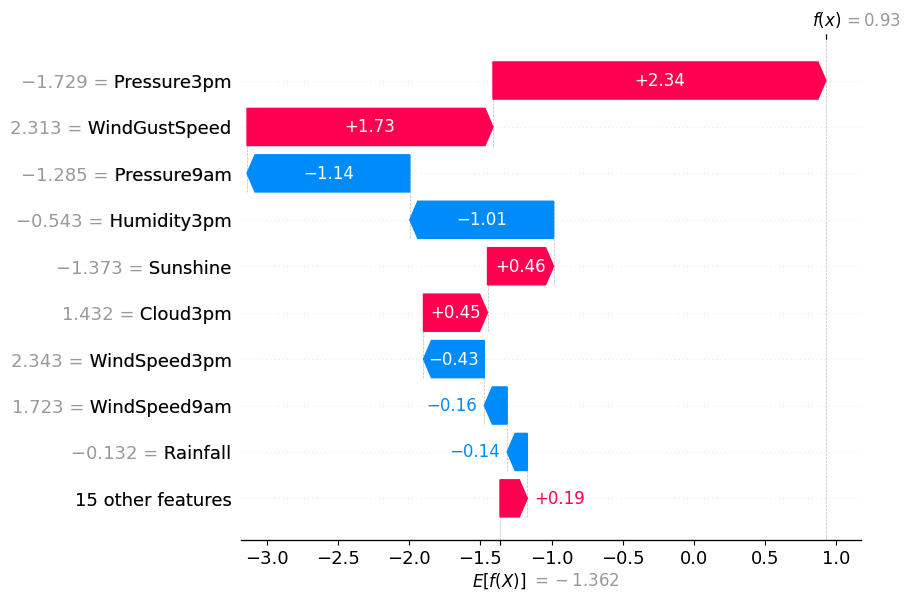

In [65]:
index = 50

classifier.predict(x_test_clasificacion)[index]

shap_valores_clasificacion = explicar_clasificacion(x_test_clasificacion)

explicacion = shap.Explanation(
    values=shap_valores_clasificacion[index],
    base_values=explicar_clasificacion.expected_value,
    feature_names=train_clasificacion_X.columns,
)


shap.plots.waterfall(explicacion)

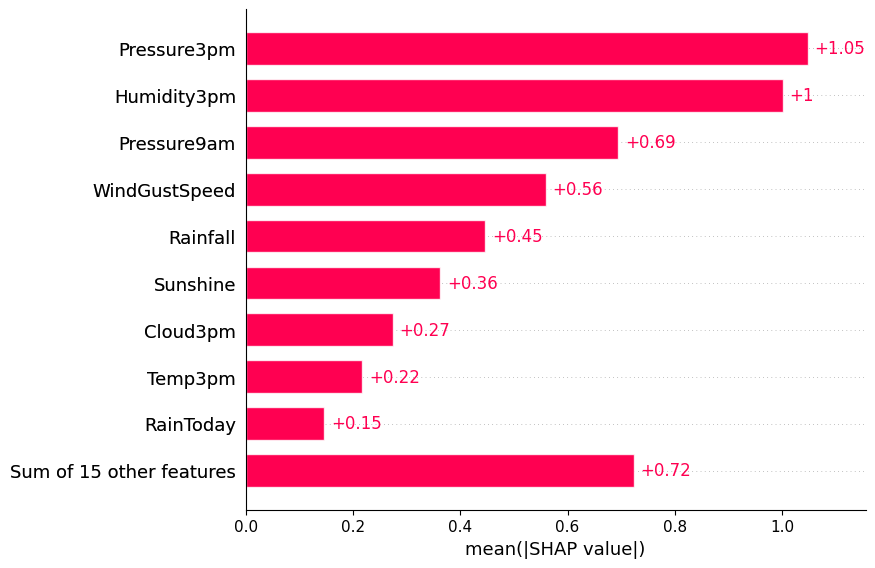

In [66]:
explicabilidad_global_clasificacion = shap.Explanation(
    shap_valores_clasificacion,
    base_values=explicar_clasificacion.expected_value,
    feature_names=train_clasificacion_X.columns,
    data=x_test_clasificacion,
)


shap.plots.bar(explicabilidad_global_clasificacion)